In [123]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'analysis'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'session'))

from imports import *
import numpy as np
import h5py, json
import matplotlib.pyplot as plt
from scipy import signal, stats
from target import build_tgt_matrix
from adapters import DatProcessor
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [124]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Question: 

    AEP responses were extensively studied mostly in anaesthetized or awake but non-engaged rodents (this has to be double-cheked of course). We know from human and animal studies that AEPs reflect both 
    - strength of exogenous signal propagation and 
    - endogenous perceptual / concious response to sound stimulation (refs should go here).
    Thus it is of a big interest to explore AEPs and underlying neural dynamics in freely-moving animals engaged in an auditory task.

## Intro: classical structure of the evoked response

    Classical Evoked Response has the following structure:

    https://en.wikipedia.org/wiki/N100

![title](assets/AEP.png)

    - Depending on the species, P1, N1, P2 and P3 components have different timing
    - P1 / N1 are thought to be more exogenous (externally-driven)
    - P2 / P3 are thought to be more endogenous (internal attention / concious modulated response)
    - depending on where it is recodred (which brain area, how deep etc.) the sign of the response can be inverted
    - we see it in gerbil AC exactly like it looks on the picture, but potential is reversed (minus down, plus up)
    
    All the refs will be insterted later of course

## Loading example session

In [125]:
# select example session
source    = '/home/sobolev/nevermind/Andrey/data'
session   = '009266_hippoSIT_2023-04-17_17-04-17'
animal    = session.split('_')[0]
dat_file  = os.path.join(source, animal, session, session + '.dat')
aeps_file = os.path.join(source, animal, session, 'AEPs.h5')
h5_file   = os.path.join(source, animal, session, session + '.h5')

# load configuration and timeline
with h5py.File(h5_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
    cfg = json.loads(f['processed'].attrs['parameters'])
    
# load AEP events
channel = 0
area = 'A1'
with h5py.File(aeps_file, 'r') as f:
    #aeps = np.array(f[str(channel)]['aeps'])
    aeps = np.array(f[area]['aeps'])
    aeps_events = np.array(f['aeps_events'])
    
# TODO find better way. Remove outliers
aeps[aeps > 5000]  =  5000
aeps[aeps < -5000] = -5000

In [126]:
# # load metrics
AEP_metrics_lims = {}
AEP_metrics_raw  = {}
AEP_metrics_norm = {}
with h5py.File(aeps_file, 'r') as f:
    #grp = f[str(channel)]
    grp = f[area]
    
    for metric_name in grp['raw']:
        AEP_metrics_raw[metric_name]  = np.array(grp['raw'][metric_name])
        AEP_metrics_norm[metric_name] = np.array(grp['norm'][metric_name])
        AEP_metrics_lims[metric_name] = [int(x) for x in grp['raw'][metric_name].attrs['limits'].split(',')]

In [127]:
tgt_dur = cfg['experiment']['target_duration']
tgt_matrix = build_tgt_matrix(tl, aeps_events, cfg['experiment']['target_duration'])

aeps.shape, tgt_matrix.shape

((5067, 200), (73, 5))

## 1.1 Example Auditory Evoked Responses (AEPs) in the raw signal

In [41]:
# raw LFP with present / missing AEPs
dat_processor = DatProcessor(dat_file)

duration = 1.0
offset = 8*60 + 17.5
tml = np.linspace(offset, offset + duration, int(duration * 30000))
ex_block = dat_processor.read_block_from_dat(duration, offset)
aeps_ev_sel = aeps_events[(aeps_events[:, 0] > offset) & (aeps_events[:, 0] < offset + duration + 0.2)]

Text(0, 0.5, 'LFP, uv')

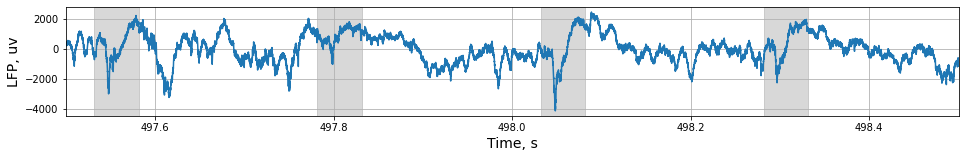

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(16, 2))
ax.plot(tml, ex_block[:, 1])  # plot 2nd channel
for ev in aeps_ev_sel:
    ax.axvspan(ev[0], ev[0] + 0.05, alpha=0.3, color='gray')
ax.grid()
ax.set_xlim(offset, offset + duration)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('LFP, uv', fontsize=14)

### Figure notes:
    
    Example 1 second of raw LFP recording (channel 2) of the SIT frequency discrimination session.
    Sound stimulations are highlighted in gray. 
    Note very dynamic structure of AEP responses. Note that the AEP to the second pulse is almost absent.

## 1.2 AEP profiles for an example session

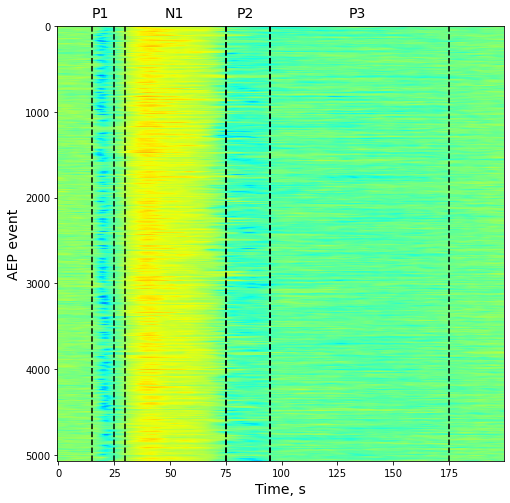

In [128]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(aeps, aspect='auto', cmap='jet')
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('AEP event', fontsize=14)
for key, value in AEP_metrics_lims.items():
    ax.axvline(value[0], color='black', ls='--')
    ax.axvline(value[1], color='black', ls='--')
    ax.text(value[0] + (value[1] - value[0])/2 - 5, -100, key, fontsize=14)

### Figure notes:
    
    All AEP profiles for an example session. 
    Black dashed lines indicate separation of different components (P1, N1, P2, P3) in time.
    Note variability in different components across time (Y-axis).

## 1.3 Example of AEP metric evolution in time

Text(0.5, 0, 'Time, s')

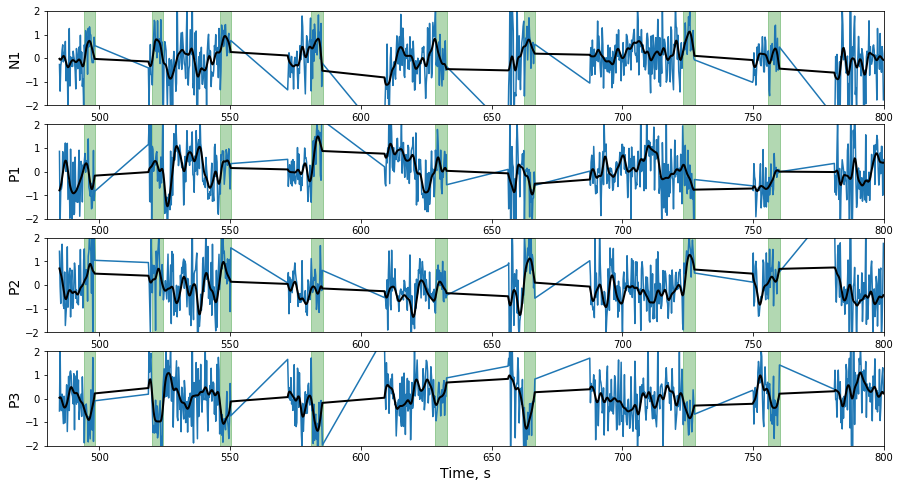

In [88]:
t_start, t_end = 480, 800  # secs
aeps_events_idxs = np.where((aeps_events[:, 0] > t_start) & (aeps_events[:, 0] < t_end))[0]
aeps_events_times = aeps_events[aeps_events_idxs][:, 0]

fig, axes = plt.subplots(4, 1, figsize=(15, 4*2))

for i, metric in enumerate(AEP_metrics_raw.keys()):
    axes[i].plot(aeps_events_times, stats.zscore(AEP_metrics_raw[metric][aeps_events_idxs]))
    axes[i].plot(aeps_events_times, AEP_metrics_norm[metric][aeps_events_idxs], lw=2, color='black')
    axes[i].set_xlim(t_start, t_end)
    axes[i].set_ylim(-2, 2)
    axes[i].set_ylabel(metric, fontsize=14)
    for tgt_event in tgt_matrix:
        axes[i].axvspan(tl[tgt_event[0]][0], tl[tgt_event[1]][0], alpha=0.3, color='green')
axes[3].set_xlabel('Time, s', fontsize=14)

### Figure notes:
    
    Dynamics of AEP components (N1, P1, P2, P3) for selected period from the example session.
    Blue: z-scored raw AEP metric values; black: z-scored smoothed AEP metric values, green shadings: time in target island.
    Inter-trial intervals (strait lines) have no AEP data, just hard to plot without them.
    Note the raw metric values are very noizy and require smoothing.
    Note in this example P1, P2 are strongly modulated by target frequency.

## 1.4 Raw and z-scored smoothed metric distributions for example session

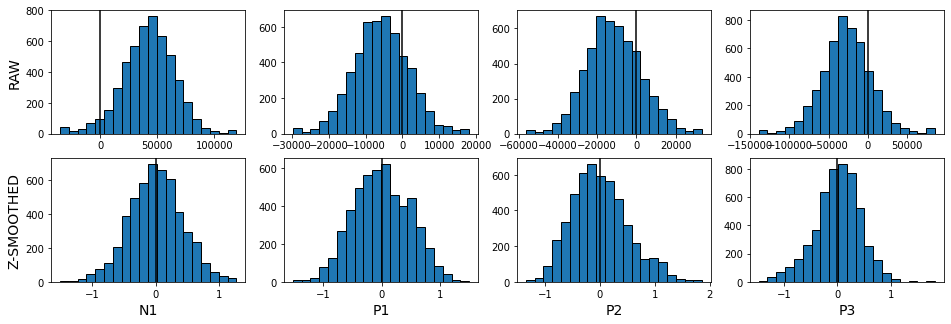

In [93]:
fig, axes = plt.subplots(2, len(AEP_metrics_lims), figsize=(16, 5))

titles = ['RAW', 'Z-SMOOTHED']
for j, metrics in enumerate([AEP_metrics_raw, AEP_metrics_norm]):
    for i, (name, data) in enumerate(metrics.items()):
        axes[j, i].hist(data, bins=20, edgecolor='black')
        axes[j, i].axvline(0, color='black')
        if j == 1:
            axes[j, i].set_xlabel(name, fontsize=14)
        if i == 0:
            axes[j, i].set_ylabel(titles[j], fontsize=14)

### Figure notes:

    AEP metric distributions for an example session.
    Just for information.

## 1.5 Some AEP metrics are correlated (example session; TBD: across sessions)

In [98]:
# metrics / units
dim = len(AEP_metrics_norm)
corr_pearson_raw  = np.zeros((dim, dim))  # N1, P1, N2, etc.
corr_pearson_norm = np.zeros((dim, dim))  # N1, P1, N2, etc.
metric_names = list(AEP_metrics_norm.keys())
for i, metric1 in enumerate(metric_names):
    for j, metric2 in enumerate(metric_names):
        m1 = AEP_metrics_raw[metric1]
        m2 = AEP_metrics_raw[metric2]
        m3 = AEP_metrics_norm[metric1]
        m4 = AEP_metrics_norm[metric2]

        corr_pearson_raw[i, j]   = stats.pearsonr(m1, m2)[0]
        corr_pearson_norm[i, j]  = stats.pearsonr(m3, m4)[0]

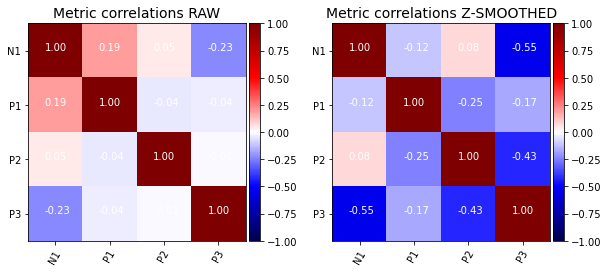

In [99]:
fig = plt.figure(figsize=(10, 4))

titles = ['RAW', 'Z-SMOOTHED']
for i, corr_pearson in enumerate([corr_pearson_raw, corr_pearson_norm]):
    ax = fig.add_subplot(1, 2, i+1)
    im = ax.imshow(corr_pearson, cmap='seismic', vmin=-1)
    ax.set_xticks(range(corr_pearson.shape[1]))
    ax.set_xticklabels(metric_names, rotation=60)
    ax.set_yticks(range(corr_pearson.shape[0]))
    _ = ax.set_yticklabels(metric_names)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title('Metric correlations %s' % titles[i], fontsize=14)
    for p in range(corr_pearson.shape[0]):
        for q in range(corr_pearson.shape[1]):
            ax.text(p - 0.2, q, '%.2f' % corr_pearson[p, q], color='white')

### Figure notes:

    AEP metric correlations for an example session.
    Note a difference between raw / smoothed values (need to find an explanation).
    Note a strong correlation between N1 / P3 for this example. This is actually very important for the future.
    To be done: compute across sessions.

## 1.5 AEP dynamics reflect behavioral relevance of the presented sounds

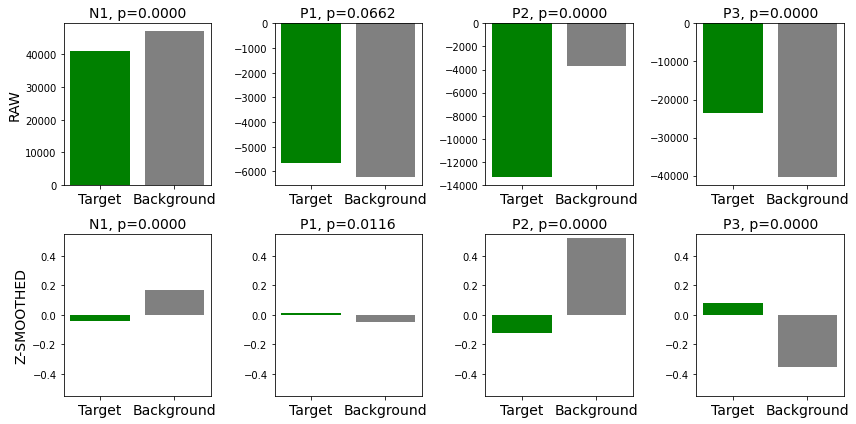

In [115]:
idxs_inside  = np.where(aeps_events[:, 1] == 2)[0]
idxs_outside = np.where(aeps_events[:, 1] == 1)[0]

fig, axes = plt.subplots(2, len(AEP_metrics_lims), figsize=(12, 6))
titles = ['RAW', 'Z-SMOOTHED']

for j, metrics in enumerate([AEP_metrics_raw, AEP_metrics_norm]):
    for i, data in enumerate(metrics.values()):
        bgr_data = data[idxs_inside]
        tgt_data = data[idxs_outside]
        d, k2p = stats.ks_2samp(bgr_data, tgt_data)        

        #axes[j, i].boxplot([tgt_data, bgr_data])
        axes[j, i].bar([1, 2], [tgt_data.mean(), bgr_data.mean()], color=('green', 'grey'))
        axes[j, i].set_xticks([1, 2])  # set correct ticks and labels
        axes[j, i].set_xticklabels(['Target', 'Background'], fontsize=14)
        axes[j, i].set_title("%s, p=%.4f" % (list(AEP_metrics_lims.keys())[i], k2p), fontsize=14)
    
        if i == 0:
            axes[j, i].set_ylabel(titles[j], fontsize=14)
        if j == 1:
            axes[j, i].set_ylim(-0.55, 0.55)
fig.tight_layout()

### Figure notes:

    Difference of the AEP components in target / background for an example session.
    Note almost all the components are significantly (Kolmogorov-Smirnov 2-sample) different between target / background sounds.
    Very important: it doesn't hold for all the sessions! In this example animal was very engaged in the task.
    In many sessions animal engagement is not that clear, so just averaging doesn't look that good.
    TBD: compute across sessions.
    
    Discussion: simple target frequency tuning might be an explanation. But then we shouldn't see such variance in the dynamics WITHIN the same frequency presentation. So more likely that it is due to behavioral relevance and top-down modulation.

## 1.6 AEP components predict behavioral performance

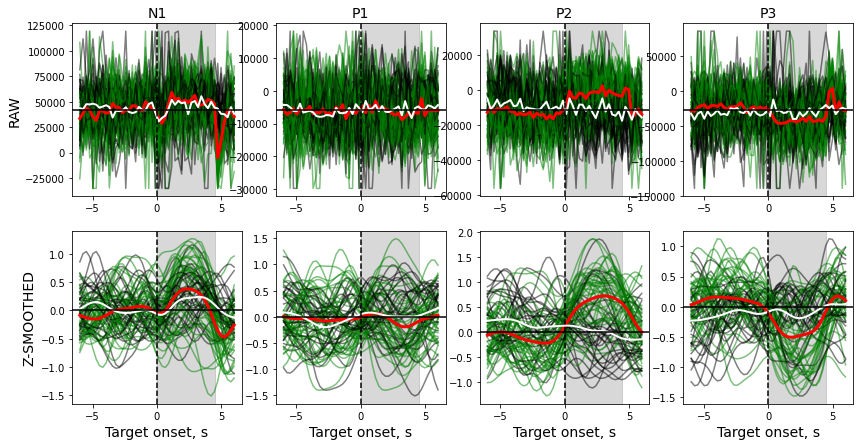

In [119]:
fig = plt.figure(figsize=(14, 7))

t_lag  = 6  # seconds
tgt_starts = []
y_labels = ['RAW', 'Z-SMOOTHED']
dim = len(AEP_metrics_lims)
times = np.linspace(-6, 6, 48)

for i, metric_type in enumerate([AEP_metrics_raw, AEP_metrics_norm]):
    for j, (m_name, metric) in enumerate(metric_type.items()):
        ax = fig.add_subplot(2, dim, i*dim + j + 1)
        means_succ = []
        means_miss = []

        for idx_aep, result in tgt_matrix[:, (2, 4)]:  # iterate over all tgt entrances / exits
            if idx_aep < 24 or idx_aep > len(aeps_events) - 24:
                continue
            clr = 'green' if result == 1 else 'black'
            ev_idxs = np.arange(idx_aep - 24, idx_aep + 24)  # +- 6 secs
            ax.plot(times, metric[ev_idxs], color=clr, alpha=0.5)
            if result == 1:
                means_succ.append(metric[ev_idxs])
            else:
                means_miss.append(metric[ev_idxs])

        # plot means
        ax.plot(times, np.array(means_succ).mean(axis=0), color='red', lw=3)
        ax.plot(times, np.array(means_miss).mean(axis=0), color='white', lw=2)
        ax.axvline(0, ls='--', color='black')
        ax.axhline(metric.mean(), color='black')
        if i == 0:
            ax.set_title(m_name, fontsize=14)
        if i == 1:
            ax.set_xlabel('Target onset, s', fontsize=14)
        ax.axvspan(0, tgt_dur, alpha=0.3, color='gray')
        if j == 0:
            ax.set_ylabel(y_labels[i], fontsize=14)

### Figure notes:

    Dynamics of AEP components between successful (green) and missed (black) entrances to the target for an example session.
    Mean of successful / missed are plotted in red / white respectively.
    Note strong increase / decrease in P2 / P3 components in successful entrances.
    Note failed entrances don't show significant dynamics.

## VERY IMPORTANT: this doesn't hold for all sessions!

    In most of the sessions animal engagement is not that clear. So the dynamics of AEP components (which are presumably correlate with cognitive state of task engagement) are not that obvious and don't display such strong difference in dynamics.